In [1]:
from keras.models import load_model
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score

2024-04-14 21:38:27.597873: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-14 21:38:27.597972: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-14 21:38:27.717717: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# model_resnet = load_model('/kaggle/input/topsevenmodels/resnet101_9816.h5')
model_mobilenet = load_model('/kaggle/input/topsevenmodels/mobilenetv2_9861.h5')
model_inception = load_model('/kaggle/input/topsevenmodels/inceptionv3_9863.h5')
model_nasnetmobile = load_model('/kaggle/input/topsevenmodels/nasnet_9876.h5')
model_densenet = load_model('/kaggle/input/topsevenmodels/densenet121_9876.h5')
model_xception = load_model('/kaggle/input/topsevenmodels/xception_9874.h5')
model_vgg = load_model('/kaggle/input/topsevenmodels/vgg19_9833.h5')
model_efficient = load_model('/kaggle/input/efficientnetb4-9839/efficientnetb4_9839.h5')
model_inceptionresnet = load_model('/kaggle/input/inceptionresnetv2-9660/inceptionresnetv2_9660.h5')

In [3]:
train_data = pd.read_csv("/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-train.csv")
val_data = pd.read_csv("/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-validation.csv")
test_data = pd.read_csv("/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-test.csv")

train_dir = '/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-train/BTTAIxNYBG-train'
val_dir = '/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-validation/BTTAIxNYBG-validation'
test_dir = '/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-test/BTTAIxNYBG-test'

In [4]:
def ensemble_predictions(models, generator):
    predictions = [model.predict(generator, steps=len(generator)) for model in models]
    avg_preds = np.mean(predictions, axis=0)
    return avg_preds

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Setup generators
batch_size = 64
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_dir,
    x_col="imageFile",
    y_col="classLabel",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    directory=val_dir,
    x_col="imageFile",
    y_col="classLabel",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 81946 validated image filenames belonging to 10 classes.
Found 10244 validated image filenames belonging to 10 classes.


In [6]:
from itertools import combinations

# Define a list of candidate models
candidate_models = [model_mobilenet, model_inception, model_nasnetmobile, model_densenet, model_xception, model_vgg, model_efficient, model_inceptionresnet]

best_accuracy = 0
best_ensemble = None

# Generate all possible combinations of models for the current ensemble size
ensemble_combinations = combinations(candidate_models, 7)

# Iterate over each combination
for models_combination in ensemble_combinations:
    # Create a list of models for the current combination
    models = list(models_combination)

    # Evaluate the ensemble
    val_preds = ensemble_predictions(models, val_generator)
    val_labels = np.argmax(val_preds, axis=1)
    val_accuracy = accuracy_score(val_generator.classes, val_labels)

    # Check if this ensemble has the best accuracy so far
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_ensemble = models

print(f'Best Validation Accuracy: {best_accuracy}')
print(f'Best Ensemble Models: {best_ensemble}')

# Train the final ensemble using all available data
final_val_preds = ensemble_predictions(best_ensemble, val_generator)
final_val_labels = np.argmax(final_val_preds, axis=1)
final_val_accuracy = accuracy_score(val_generator.classes, final_val_labels)
print(f'Final Validation Accuracy with Best Ensemble: {final_val_accuracy}')

161/161 [==============================] - 94s 583ms/step
Best Validation Accuracy: 0.10630613041780554
Best Ensemble Models: [<keras.src.engine.functional.Functional object at 0x79c829f5db70>, <keras.src.engine.functional.Functional object at 0x79c778337be0>, <keras.src.engine.functional.Functional object at 0x79c73c77c9d0>, <keras.src.engine.functional.Functional object at 0x79c73c1f4040>, <keras.src.engine.functional.Functional object at 0x79c72c2892d0>, <keras.src.engine.functional.Functional object at 0x79c72c2c5d20>, <keras.src.engine.functional.Functional object at 0x79c71817bc10>]
161/161 [==============================] - 93s 575ms/step
Final Validation Accuracy with Best Ensemble: 0.10279187817258884


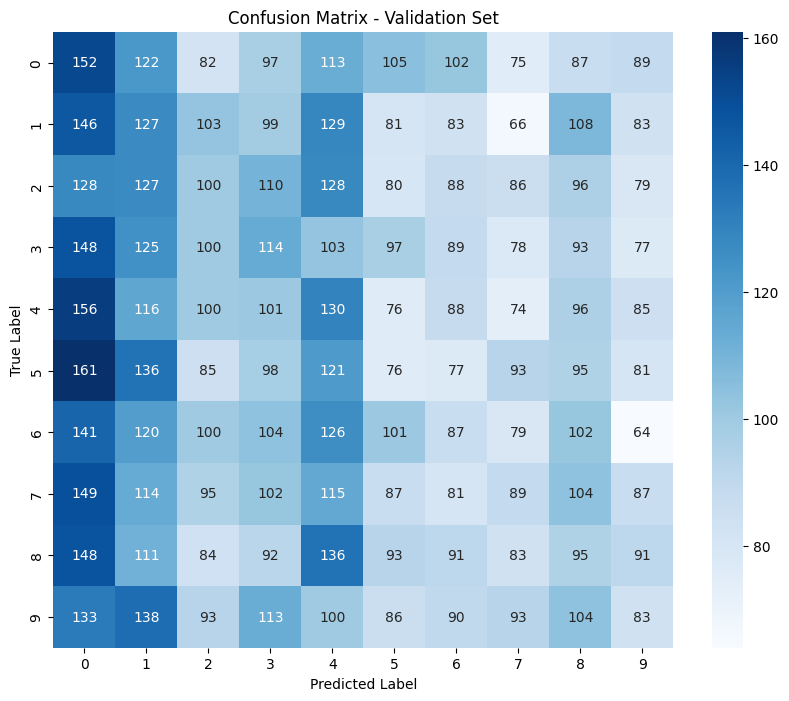

In [7]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(val_generator.classes, final_val_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [8]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    directory=test_dir,
    x_col="imageFile",
    y_col=None,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)
test_preds = ensemble_predictions(best_ensemble, test_generator)
test_labels = np.argmax(test_preds, axis=1)

test_data['classID'] = test_labels
test_data[['uniqueID', 'classID']].to_csv('ensemble_predictions.csv', index=False)

Found 30690 validated image filenames.
480/480 [==============================] - 288s 593ms/step
